In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import re
def extract_numbers_from_filename(filename):
    # Use regular expression to find numbers in the filename
    match = re.search(r'\d+', filename)

    # If numbers are found, convert them to an integer
    if match:
        return int(match.group())
    else:
        return None

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_blocky_mask(img):
    scale_factor = 0.15
    _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    small_lr_back = cv2.resize(binary_mask, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
    blocky_lr_back = cv2.resize(small_lr_back, img.shape[::-1], interpolation=cv2.INTER_NEAREST)
    return blocky_lr_back

def remove_small_blobs(mask, min_blob_size=50):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours (blobs)
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_blob_size]

    # Create an empty mask to draw the filtered contours
    filtered_mask = np.zeros_like(mask)

    # Draw the filtered contours on the mask
    cv2.drawContours(filtered_mask, filtered_contours, -1, 255, thickness=cv2.FILLED)

    return filtered_mask

def expand_white_pixels(mask, kernel_size=3):
    # Create a square kernel with the given size
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    # Apply dilation
    expanded_mask = cv2.dilate(mask, kernel, iterations=3)
    expanded_mask = remove_small_blobs(expanded_mask, 60)
    return expanded_mask

def create_mask(img_path, smoothing=True):
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Canny edge detection with different thresholds
    if smoothing:
      # gray_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
      gray_img = cv2.bilateralFilter(gray_img, d=10, sigmaColor=75, sigmaSpace=75)
    edges = cv2.Canny(gray_img, 50, 150)
    contours, _ = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(edges, contours, -1, (0, 255, 0), 2)
    edges = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)[1]
    # Draw contours on edges
    mask = expand_white_pixels(edges)  # Expand white pixels

    # Convert BGR to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.subplot(122)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.show()

    return cv2.bitwise_not(mask)

/content/drive/MyDrive/KernelGAN-Masks/imgs/img1


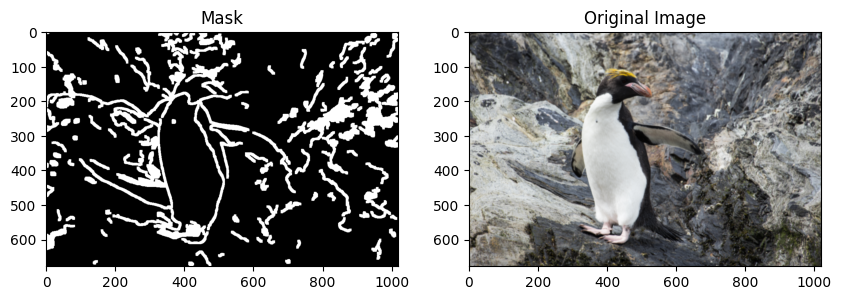

/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img1/obj_lr_mask.png


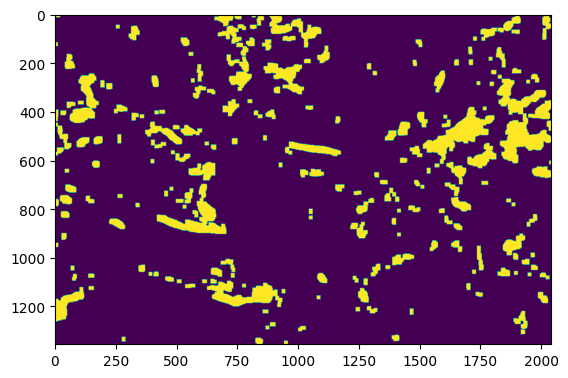

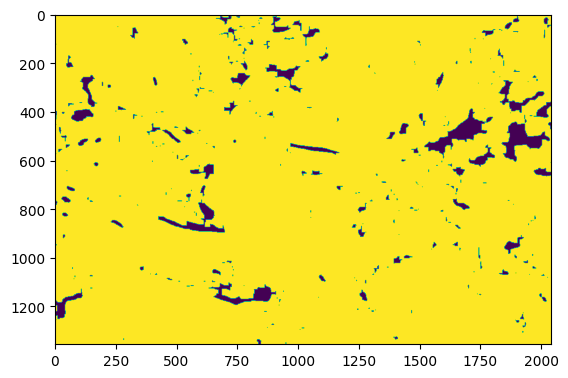

/content/drive/MyDrive/KernelGAN-Masks/imgs/img2


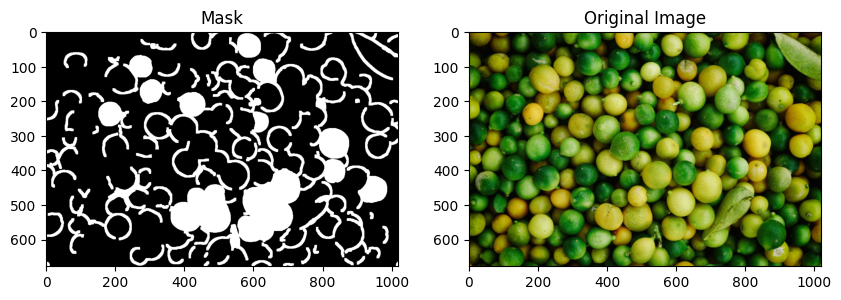

/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img2/obj_lr_mask.png


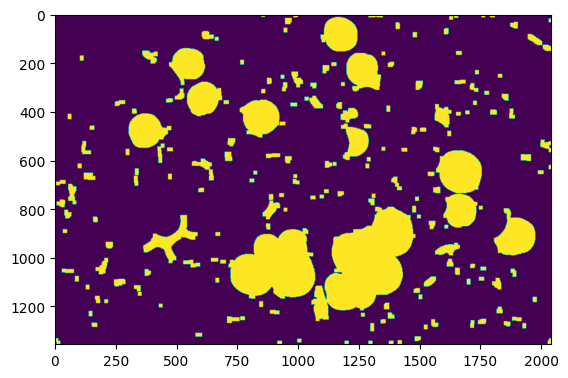

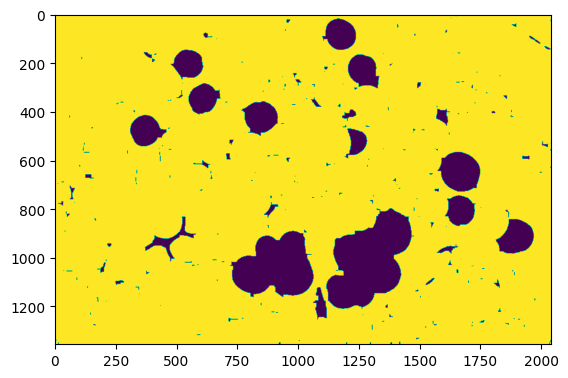

In [72]:
import os

base = "/content/drive/MyDrive/KernelGAN-Masks"
src = base + "/imgs"
dst = base + "/masks"

files = os.listdir(src)

for file_name in files:
    image_path = os.path.join(src, file_name)
    img_num = extract_numbers_from_filename(file_name)
    dir_path = os.path.join(dst, 'img' + str(img_num))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    print(image_path)
    for img in os.listdir(image_path):
        if "lr" in img:
            image_path_lr = os.path.join(image_path, img)
            break
    lr_back = create_mask(image_path_lr)

    new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
    new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
    new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
    new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

    hr_back = create_blocky_mask(cv2.resize(lr_back, dsize=[lr_back.shape[1]*2, lr_back.shape[0]*2], interpolation=cv2.INTER_NEAREST))
    hr_obj = create_blocky_mask(cv2.bitwise_not(hr_back))
    lr_obj = cv2.bitwise_not(lr_back)

    cv2.imwrite(new_path_back_hr, hr_back)
    cv2.imwrite(new_path_back_lr, lr_back)
    cv2.imwrite(new_path_obj_hr, hr_obj)
    cv2.imwrite(new_path_obj_lr, lr_obj)

    print(new_path_back_hr)
    print(new_path_back_lr)
    print(new_path_obj_hr)
    print(new_path_obj_lr)

    plt.imshow(hr_obj)
    plt.show()
    plt.imshow(hr_back)
    plt.show()